In [11]:
import pandas as pd
import numpy as np
import pyflux as pf
import matplotlib.pyplot as plt
from fbprophet import Prophet
    
%matplotlib inline
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

### Load the data

For this work, we're going to use the same retail sales data that we've used before. It can be found in the examples directory of this repository.

In [122]:
sales_df = pd.read_csv('../examples/retail_sales.csv', index_col='date', parse_dates=True)

In [123]:
sales_df.head()

,sales
date,
2009-10-01,338630
2009-11-01,339386
2009-12-01,400264
2010-01-01,314640
2010-02-01,311022


Like all good modeling projects, we need to take a look at the data to get an idea of what it looks like.

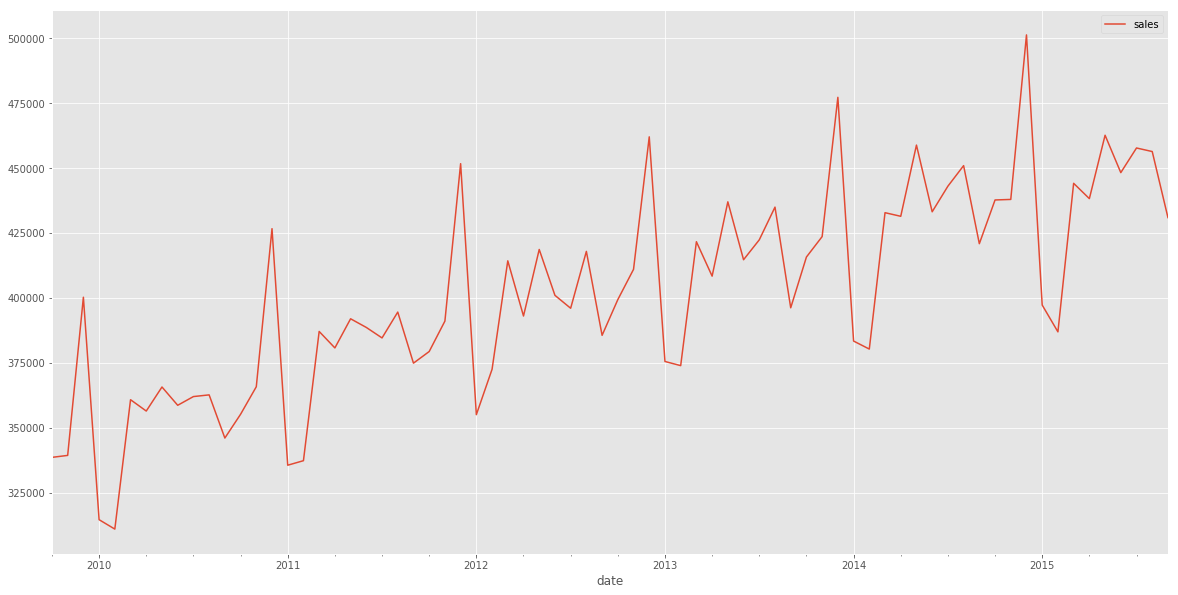

In [22]:
sales_df.plot()

It's pretty clear from this data that we are looking at a trending dataset with some seasonality. This is actually a pretty good datset for prophet since the additive model and prophet's implemention does well with this type of data.  

With that in mind, let's take look at what prophet does from a modeling standpoint to compare with the dynamic linear regression model.  For more details on this, you can take a look at my blog post titled **Forecasting Time Series data with Prophet – Part 4** (http://pythondata.com/forecasting-time-series-data-prophet-part-4/)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


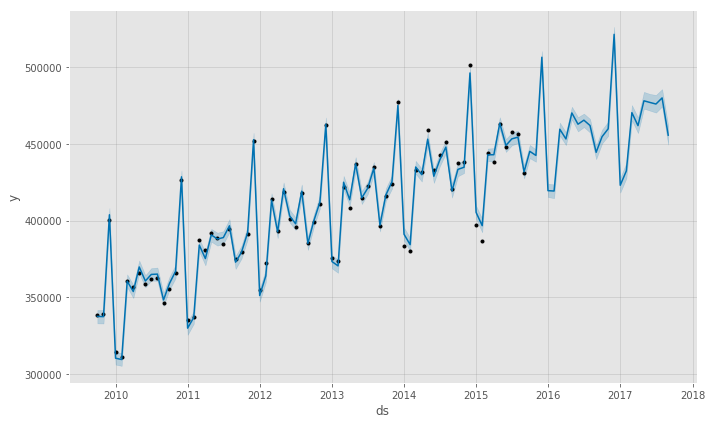

In [166]:
# Prep data for prophet and run prophet
df = sales_df.reset_index()
df=df.rename(columns={'date':'ds', 'sales':'y'})

model = Prophet(weekly_seasonality=True)
model.fit(df);
future = model.make_future_dataframe(periods=24, freq = 'm')

forecast = model.predict(future)
model.plot(forecast);

With our prophet model ready for comparison, let's build a model with pyflux's dynamic linear regresion model.


### More Data Viz 

Now that we've run our prophet model and can see what it has done, its time to walk through what I call the 'long form' of model building. This is more involved than throwing data at a library and accepting the results.

For this data, let's first look at the differenced log values of our sales data (to try to make it more stationary).

In [51]:
diff_log = pd.DataFrame(np.diff(np.log(sales_df['sales'].values)))
diff_log.index = sales_df.index.values[1:sales_df.index.values.shape[0]]
diff_log.columns = ["Sales DiffLog"]


In [64]:
sales_df['logged']=np.log(sales_df['sales'])

In [65]:
sales_df.tail()

,sales,diff_log,logged
date,,,
2015-05-01,462615,13.044650,13.044650
2015-06-01,448229,13.013060,13.013060
2015-07-01,457710,13.033991,13.033991
2015-08-01,456340,13.030993,13.030993
2015-09-01,430917,12.973671,12.973671


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4162a9d4d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f4162998a50>], dtype=object)

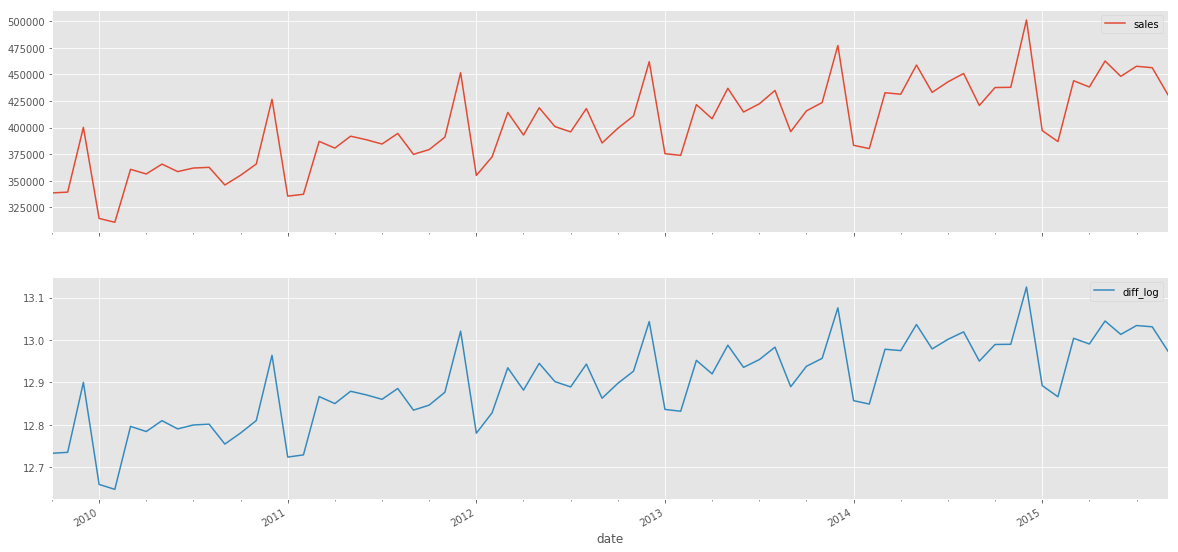

In [60]:
sales_df.plot(subplots=True)

With our original data (top pane in orange), we can see a very pronounced trend. With the differenced log values (bottom pane in blue), we've removed that trend and made the data staionary (or hopefully we have).

Now, lets take a look at an autocorrelation plot, which will tell us whether the future sales is correlated with the past data. I won't go into detail on autocorrelation, but if you don't understand whether you have autocorrelation (and to what degree), you might be in for a hard time :)

Let's take a look at the autocorrelation plot (acf) if the differenced log values as well as the ACF of the square of the differenced log values.


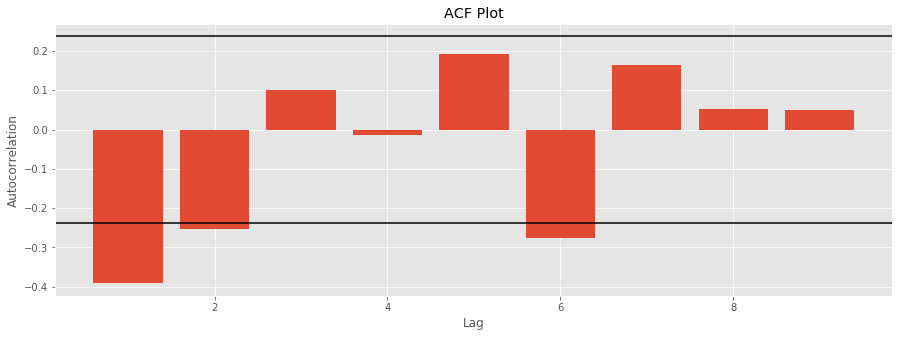

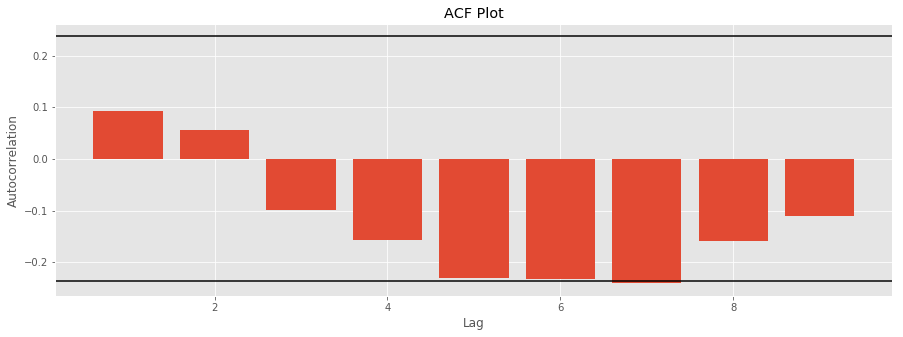

In [34]:
pf.acf_plot(diff_log.values.T[0])
pf.acf_plot(np.square(diff_log.values.T[0]))

We can see that at a lag of 1 and 2 months, there are positive correlations for sales but as time goes on, that correlation drops quickly to a negative correlation that stays in place over time, which hints at the fact that there are some autoregressive effects within this data.  

Because of this fact, we can start our modeling by using an ARMA model of some sort.

In [70]:
Logged = pd.DataFrame(np.log(sales_df['sales']))
Logged.index = pd.to_datetime(sales_df.index)
Logged.columns = ['Sales - Logged']

In [73]:
Logged.head()

,Sales - Logged
date,
2009-10-01,12.732663
2009-11-01,12.734893
2009-12-01,12.899880
2010-01-01,12.659184
2010-02-01,12.647619


In [160]:
modelLLT = pf.LLT(data=Logged)

In [161]:
x = modelLLT.fit()
x.summary()

LLT                                                                                                       
======================================================= ==================================================
Dependent Variable: Sales - Logged                      Method: MLE                                       
Start Date: 2009-10-01 00:00:00                         Log Likelihood: 79.4161                           
End Date: 2015-09-01 00:00:00                           AIC: -152.8322                                    
Number of observations: 72                              BIC: -146.0022                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Sigma^2 irregular                        0.00404690                                                       
Sigma^2 level                        

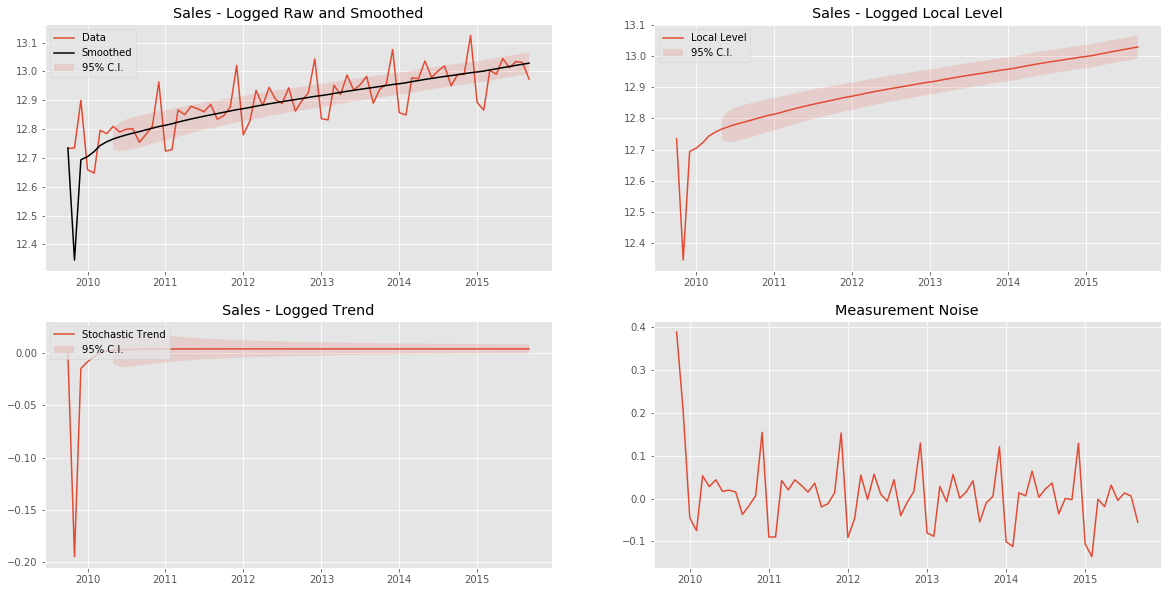

In [77]:
model.plot_fit(figsize=(20,10))

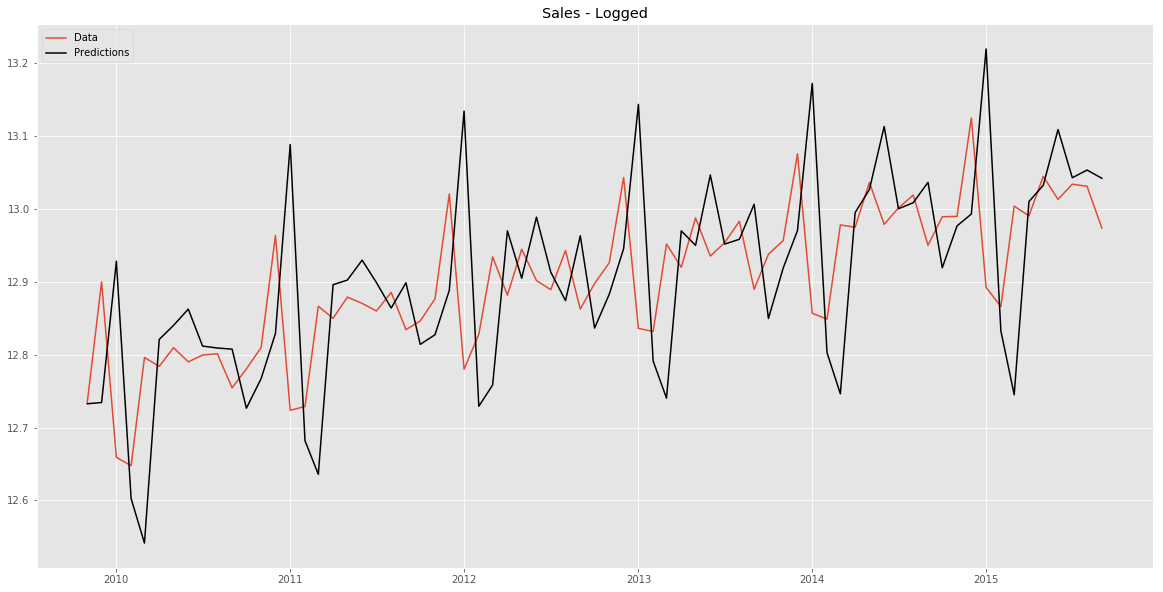

In [162]:
modelLLT.plot_predict_is(h=len(Logged)-1, figsize=(20,10))

In [163]:
predicted = modelLLT.predict_is(h=len(Logged)-1)
predicted.columns = ['Predicted']

In [164]:
predicted.tail()

,Predicted
date,
2015-05-01,13.032417
2015-06-01,13.108955
2015-07-01,13.042818
2015-08-01,13.053347
2015-09-01,13.042059


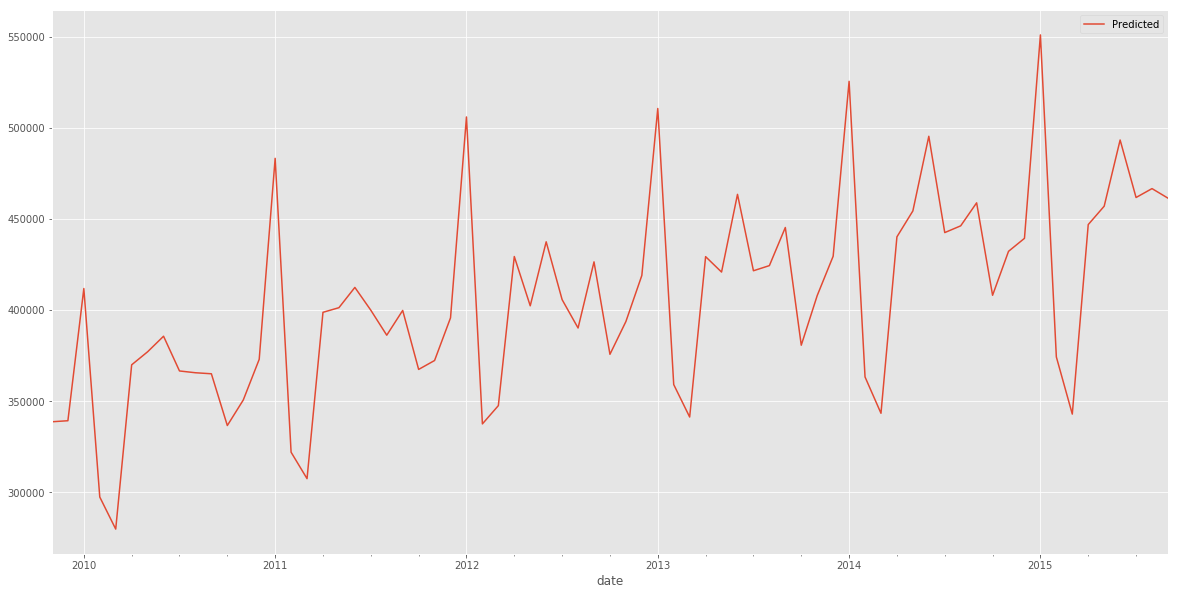

In [165]:
np.exp(predicted).plot()

In [ ]:
sales_df_future=sales_df
sales_df

In [181]:
final_sales=sales_df.merge(np.exp(predicted),right_on=predicted.index)

TypeError: object of type 'NoneType' has no len()

In [176]:
final_sales = sales_df.merge()

AttributeError: 'function' object has no attribute 'merge'

In [173]:
final_sales.tail()

,sales,Predicted
date,,
2015-05-01,462615,456989.958343
2015-06-01,448229,493340.358610
2015-07-01,457710,461767.885997
2015-08-01,456340,466655.649862
2015-09-01,430917,461417.638666


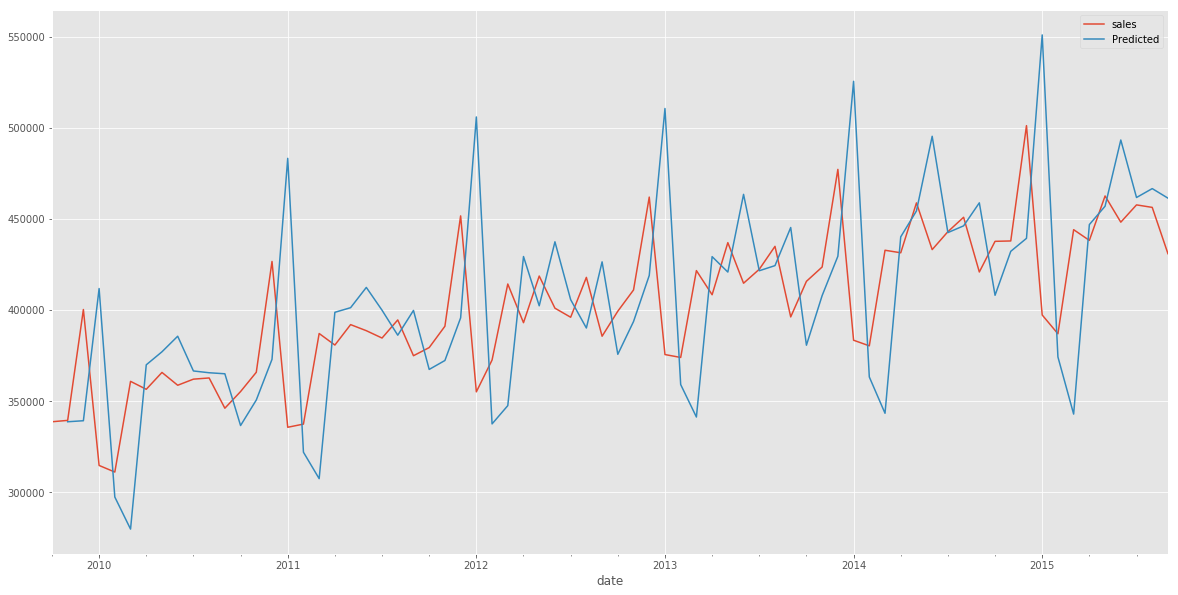

In [157]:
final_sales.plot()